<a href="https://colab.research.google.com/github/argonne-lcf/ai-science-training-series/blob/main/04_intro_to_llms/IntroLLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel and distributed Deep Learning

## Author: Marieme Ngom, Argonne National Laboratory
(combining and adapting materials/discussion evolved over time by Huihuo Zheng, Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, Varuni Sastry, Sam Foreman, Archit Vasan, Carlo Graziani, Tanwi Mallick, and Venkat Vishwanath)
## Outline 
### Day 1
#### Evolution of computig systems
#### Parallel computing
#### Introduction to Deep Learning
#### Parallel computing in AI

### Day 2
#### Brief Introduction to LLMs
#### Hands-on LLM training



# Parallel computing
**Parallel computing** refers to the process of breaking down larger problems into smaller, independent, often similar parts that can be executed simultaneously by multiple processors communicating via network or shared memory, the results of which are combined upon completion as part of an overall algorithm.

## $\pi$ example
We can calculate the value of $\pi$ using a MPI parallelized version of the Monte Carlo method. The basic idea is to estimate $\pi$ by randomly sampling points within a square and determining how many fall inside a quarter circle inscribed within that square.

![PI](https://www.101computing.net/wp/wp-content/uploads/estimating-pi-monte-carlo-method.png)

The ratio between the area of the circle and the square is

$\frac{N_\text{in}}{N_\text{total}} = \frac{\pi r^2}{4r^2} = \frac{\pi}{4}$

Therefore, we can calculate $\pi$ using 
$\pi = \frac{4N_\text{in}}{N_\text{total}} $

Pi = 3.088
Time: 126.22724890708923


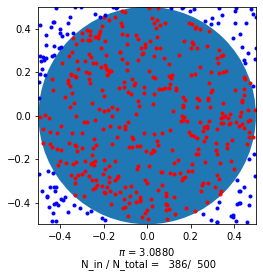

In [2]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
import time
fig, ax = plt.subplots()
#ax = fig.add_subplot(111)
circle = plt.Circle(( 0. , 0. ), 0.5 )
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
ax.add_patch(circle)
ax.set_aspect('equal')
N = 500
Nin = 0
t0 = time.time()
for i in range(1, N+1):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
        plt.plot([x], [y], 'o', color='r', markersize=3)
    else:
        plt.plot([x], [y], 'o', color='b', markersize=3)
    display(fig)
    plt.xlabel("$\pi$ = %3.4f \n N_in / N_total = %5d/%5d" %(Nin*4.0/i, Nin, i))
    clear_output(wait=True)

res = np.array(Nin, dtype='d')
t1 = time.time()
print(f"Pi = {res/float(N/4.0)}")
print("Time: %s" %(t1 - t0))

### MPI example
```python
from mpi4py import MPI
import numpy as np
import random
import time
comm = MPI.COMM_WORLD

N = 5000000
Nin = 0
t0 = time.time()
for i in range(comm.rank, N, comm.size):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
res = np.array(Nin, dtype='d')
res_tot = np.array(Nin, dtype='d')
comm.Allreduce(res, res_tot, op=MPI.SUM)
t1 = time.time()
if comm.rank==0:
    print(res_tot/float(N/4.0))
    print("Time: %s" %(t1 - t0))
```

In [3]:
# !pip install wget

In [4]:
# import wget

# # Download a file
# url = "https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/mpi_pi.py"
# filename = wget.download(url)
# print(f"Downloaded: {filename}")

# # With custom filename
# # wget.download(url, "custom_name.txt")

In [5]:
!pip install mpi4py

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
! mpirun -np 1 python3 mpi_pi.py

Number of processes: 1
Pi = 3.1415696
Time: 7.694227


In [11]:
! mpirun -np 2 python3 mpi_pi.py

Number of processes: 2
Pi = 3.1407192
Time: 3.855134


In [12]:
! mpirun -np 4 python3 mpi_pi.py

Number of processes: 4
Pi = 3.1427232
Time: 3.463451


# Introduction to Deep Neural Networks

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset. 

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>


In [13]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [14]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 404: Not Found




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [15]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [16]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

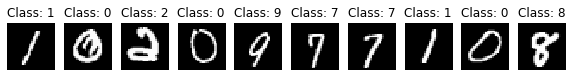

In [17]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression. 
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication. 

Note, like before, we consider multiple examples at once, adding another dimension to the input. 


 <img src="images/LinearModel_1.png"  align="center"/>
 


The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b).
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd). For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate which controls how far we move during each step. 

In [18]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [19]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.





In [20]:
batch_size = 128
# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [21]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [22]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [23]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5033041632175446, accuracy: 87.56041666666667
Epoch 0: val. loss: 0.49571036373047117, val. accuracy: 87.48333333333333
Epoch 1: training loss: 0.42243886295954386, accuracy: 88.96666666666667
Epoch 1: val. loss: 0.4132488040213889, val. accuracy: 88.83333333333333
Epoch 2: training loss: 0.38830087157090504, accuracy: 89.61041666666667
Epoch 2: val. loss: 0.37854414908809864, val. accuracy: 89.38333333333334
Epoch 3: training loss: 0.3682317271232605, accuracy: 90.06875
Epoch 3: val. loss: 0.35829871908781374, val. accuracy: 89.84166666666667
Epoch 4: training loss: 0.3545755144357681, accuracy: 90.4125
Epoch 4: val. loss: 0.3446517515372723, val. accuracy: 90.14999999999999
CPU times: user 33.8 s, sys: 227 ms, total: 34 s
Wall time: 34.1 s


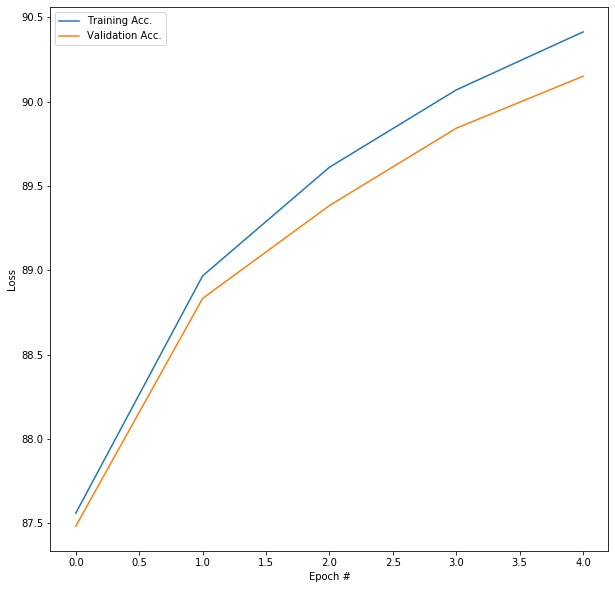

In [24]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

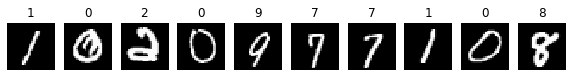

In [25]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc. 

# Prediction

Let's see how our model generalizes to the unseen test data.

In [26]:
batch_size_test = 256 
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [27]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3327, test accuracy: 90.87%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [39]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    
    # Create all subplots at once
    fig, axes = plt.subplots(1, maxtoshow, figsize=(maxtoshow, 1))
    if maxtoshow == 1:
        axes = [axes]  # Handle single subplot case
    
    ii = 0
    for i in range(batch[0].shape[0]):
        if ii >= maxtoshow:
            break
        if errors[i]:
            axes[ii].axis('off')
            axes[ii].imshow(batch[0][i,0,:,:], cmap="gray")
            axes[ii].set_title("%d (%d)" % (rounded[i], batch[1][i]))
            ii += 1

Here are the first 10 images from the test data that this small model classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


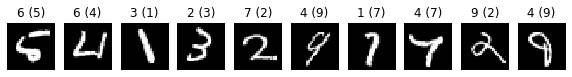

In [40]:
show_failures(linear_model, test_dataloader)

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn_annotated.jpg"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="images/acc_under_over.webp"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [34]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [35]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [36]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.6752073226769765, accuracy: 80.42708333333334
Epoch 0: val. loss: 0.6644519985990321, val. accuracy: 80.18333333333332
Epoch 1: training loss: 0.382418873667717, accuracy: 89.17500000000001
Epoch 1: val. loss: 0.3721171000853498, val. accuracy: 89.20833333333333
Epoch 2: training loss: 0.3080000270605087, accuracy: 91.18333333333334
Epoch 2: val. loss: 0.3009592083857415, val. accuracy: 91.025
Epoch 3: training loss: 0.2527356160680453, accuracy: 92.60000000000001
Epoch 3: val. loss: 0.24874528315156064, val. accuracy: 92.34166666666667
Epoch 4: training loss: 0.21959587013721465, accuracy: 93.52916666666667
Epoch 4: val. loss: 0.21943715143393963, val. accuracy: 93.2
CPU times: user 34.9 s, sys: 447 ms, total: 35.3 s
Wall time: 35.4 s


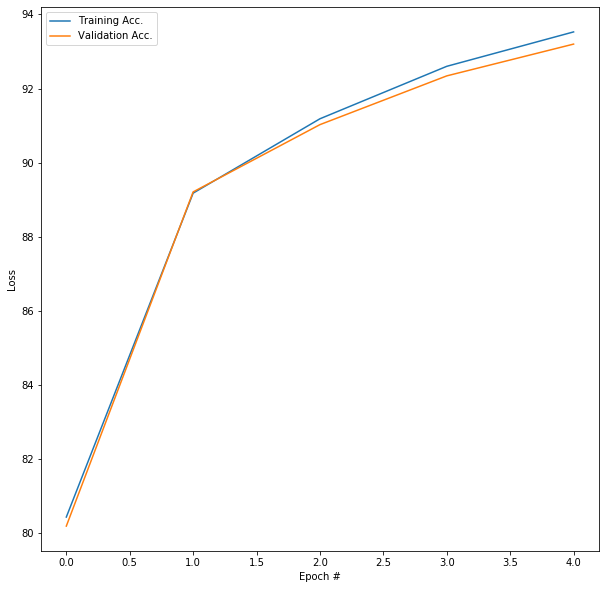

In [37]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


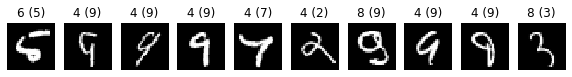

In [41]:
show_failures(nonlinear_model, test_dataloader)

# training on the GPU (Bamba, can you please try this on AWS and see how to make it run on 1 gpu)

In [44]:
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


nonlinear_model = NonlinearClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [45]:
def train_one_epoch_device(dataloader, model, loss_fn, optimizer,device):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [46]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch_device(train_dataloader, linear_model, loss_fn, optimizer,device)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.3545755144357681, accuracy: 90.4125
Epoch 0: val. loss: 0.3446517515372723, val. accuracy: 90.14999999999999
Epoch 1: training loss: 0.3545755144357681, accuracy: 90.4125
Epoch 1: val. loss: 0.3446517515372723, val. accuracy: 90.14999999999999
Epoch 2: training loss: 0.3545755144357681, accuracy: 90.4125
Epoch 2: val. loss: 0.3446517515372723, val. accuracy: 90.14999999999999
Epoch 3: training loss: 0.3545755144357681, accuracy: 90.4125
Epoch 3: val. loss: 0.3446517515372723, val. accuracy: 90.14999999999999
Epoch 4: training loss: 0.3545755144357681, accuracy: 90.4125
Epoch 4: val. loss: 0.3446517515372723, val. accuracy: 90.14999999999999
CPU times: user 32.7 s, sys: 129 ms, total: 32.8 s
Wall time: 32.9 s


# Recap


# Parallel Computing in AI 
evolved from Sam Foreman and Huihuo Zheng

Distributed training is the process of training I models across multiple GPUs or other accelerators, with the goal of speeding up the training process and enabling the training of larger models on larger datasets.

There are two ways of parallelization in distributed training. 
* **Data parallelism**: 
    * Each worker (GPU) has a complete set of model
    * different workers work on different subsets of data. 
* **Model parallelism** 
    * The model is splitted into different parts and stored on different workers
    * Different workers work on computation involved in different parts of the model
![PI](images/parallel_computing.png)
![3D LLM](images/3DLLM.png)

## Scaling goal: 
1. Minimize cost i.e. amount of time spent training
2. Maximize performance i.e 

# Training on a single device

## Single GPU

# Training on multiplease GPUs: Data Parallelism

## Data Parallel: Forward Pass

## Data Parallel: Backward Pass

## Data Parallel: Full Setup

## Data Parallel: Training

# Communication

## AllReduce

## Reduce 

## Broadcast

## AllGather

## Scatter

# Why distributed training?

 # Going Beyond Data Parallelism
 
 ## Deepspeed+ZeRO
 
 ## Tensor (/ Model) parallelism
 
 ### Tensor (/ Model) parallel training: Example